In [1]:
import numpy as np
import copy
import math
import matplotlib.pyplot as plt

In [2]:
# calculate mu to find upper bound after partial assignment of variables
def calculate_mu(alpha, beta, Rsquare):
    multiplier = 0
    for a, b in zip(alpha, beta):
        multiplier += (a**2/b)
        
    multiplier = math.sqrt(multiplier)
    # print("multiplier = {}, Rsquare = {}".format(multiplier, Rsquare))

    mu = (1/(2*math.sqrt(Rsquare))) * multiplier

    return mu

In [3]:
# calculate upper bound after partial assignment of variables
def partial_upperBound(x, alpha, beta, Rsquare, allocated):
    alloc_val = 0
    x_copy = copy.deepcopy(x)
    for i in range(allocated):
        alloc_val += beta[i]*(x_copy[i]**2)
    R_sq_new = Rsquare - alloc_val
    # print("Rsquare = {}".format(R_sq_new))
    
    p = len(x_copy) - 1
    m = allocated - 1
    mu_val = calculate_mu(alpha[allocated:], beta[allocated:], R_sq_new)
    # print("mu = {}".format(mu_val))
    
    while(p > m):
        x_copy[p] = alpha[p] / (2*mu_val*beta[p])
        p -= 1
    
    # print(x)
    upperBound = sum([i*j for i, j in zip(alpha, x_copy)])

    return upperBound

$$ \text{Constraint:} \sum \limits _{i=1} ^{N} \beta _i x _i ^2 \leq R^2$$

In [4]:
# check for constraint satisfiability
def satisfy_Cons(x, beta, Rsquare):
    x_square = list(map(lambda n: n**2, x))
    res = sum([i*j for i, j in zip(x_square, beta)])
    if res <= Rsquare:
        return True
    return False

$$ \text{Objective:} \quad \underset{\mathbf{\underline{x}}\in Z^N}{\operatorname{max}}  \sum \limits _{i=1} ^{N} \alpha _i x _i $$

In [5]:
# calculate value of objective function
def maxObjective(x, alpha):
    return sum([i*j for i, j in zip(alpha, x)])

$$ \text{ Individual } x \text{ bounds: } \quad x _i = \sqrt{R^2/\beta _i}

In [6]:
# Individual variable bounds
def init_Xbounds(beta, Rsquare):
    xbounds = list(map(lambda b: math.ceil(math.sqrt(Rsquare/b)), beta))

    return xbounds

$$\underset{\mathbf{x _1,x _2,x _3,x _4,x _5}}{\operatorname{max}} x _1 + 2x _2 + 3x _3 + 4x _4 +5 x_5 \quad \text{ s.t. } 5x _1^2 + 4 x_2^2 + 3 x_3^2 + 2 x_4^2 + x _5^2 \geq 1000 \text{, where } R^2 = 1000 $$

In [7]:
# Required variable assignments
alpha = [1, 2, 3, 4, 5]
beta = [5, 4, 3, 2, 1]
Rsquare = 1000
lower_bound = [176]
upper_bound = 192
x = [0, 0, 0, 0, 0]

In [8]:
xbounds = init_Xbounds(beta, Rsquare)

$$ \underset{\mathbf{\underline{x}}\in R^N}{\operatorname{max}}  \sum \limits _{i=1} ^{N} \alpha _i x _i \quad \text{ s.t. } \sum \limits _{i=1} ^{N} \beta _i x _i ^2 \leq R^2$$

#### Greedy Approach

In [9]:
greedy_optim_sols = []
greedy_feasible_sols = []
iter = 0
for x1 in range(xbounds[0]):
    x = [x1, 0, 0, 0, 0]
    
    if (satisfy_Cons(x, beta, Rsquare)):
        for x2 in range(xbounds[1]):
            x = [x1, x2, 0, 0, 0]
            
            if (satisfy_Cons(x, beta, Rsquare)):
                for x3 in range(xbounds[2]):
                    x = [x1, x2, x3, 0, 0]
                    
                    if (satisfy_Cons(x, beta, Rsquare)):
                        for x4 in range(xbounds[3]):
                            x = [x1, x2, x3, x4, 0]
                            
                            if (satisfy_Cons(x, beta, Rsquare)):
                                for x5 in range(xbounds[4]):
                                    iter += 1
                                    x = [x1, x2, x3, x4, x5]
                                    obj_val = maxObjective(x, alpha)
                                    
                                    if (satisfy_Cons(x, beta, Rsquare)):
                                        greedy_feasible_sols.append(x)
                                        if obj_val == upper_bound:
                                            greedy_optim_sols.append(x)
                                    
                                    else:   break
                            
                            else:   break
                    
                    else:   break
            
            else:   break
    
    else:   break

print("Iterations: {}".format(iter))
print("Total Feasible solutions: {}".format(len(greedy_feasible_sols)))
print("Total Optimal solutions: {}".format(len(greedy_optim_sols)))
print("Optimal Solutions [x1, x2, x3, x4, x5] = {}".format(greedy_optim_sols))


Iterations: 638482
Total Feasible solutions: 604473
Total Optimal solutions: 5
Optimal Solutions [x1, x2, x3, x4, x5] = [[0, 2, 6, 10, 26], [1, 2, 4, 10, 27], [1, 2, 6, 11, 25], [1, 3, 5, 10, 26], [2, 3, 5, 11, 25]]


#### Branch and Bound Approach

In [10]:
optim_sols = []
feasible_sols = []
iter = 0

# branch on x1 value
for x1 in range(xbounds[0]):
    x = [x1, 0, 0, 0, 0]
    allocated = 1
    
    # bound on x1 value
    if (satisfy_Cons(x, beta, Rsquare)):
        part_ub = partial_upperBound(x, alpha, beta, Rsquare, allocated)
        if (part_ub < lower_bound[-1]) : 
            continue
        
        # branch on x2 value
        for x2 in range(xbounds[1]):
            x = [x1, x2, 0, 0, 0]
            allocated = 2
            
            # bound on x2 value
            if (satisfy_Cons(x, beta, Rsquare)):
                part_ub = partial_upperBound(x, alpha, beta, Rsquare, allocated)
                if (part_ub < lower_bound[-1]) : 
                    continue
                
                # branch on x3 value
                for x3 in range(xbounds[2]):
                    x = [x1, x2, x3, 0, 0]
                    allocated = 3
                    
                    # bound on x3 value
                    if (satisfy_Cons(x, beta, Rsquare)):
                        part_ub = partial_upperBound(x, alpha, beta, Rsquare, allocated)
                        if (part_ub < lower_bound[-1]) : 
                            continue
                        
                        # branch on x4 value
                        for x4 in range(xbounds[3]):
                            x = [x1, x2, x3, x4, 0]
                            allocated = 4
                            
                            # bound on x4 value
                            if (satisfy_Cons(x, beta, Rsquare)):
                                part_ub = partial_upperBound(x, alpha, beta, Rsquare, allocated)
                                if (part_ub < lower_bound[-1]) : 
                                    continue

                                # branch on x5 value
                                for x5 in range(xbounds[4]):
                                    iter += 1
                                    x = [x1, x2, x3, x4, x5]
                                    obj_val = maxObjective(x, alpha)

                                    # bound on final feasible value of objective function
                                    if (satisfy_Cons(x, beta, Rsquare)):
                                        if obj_val > lower_bound[-1]:
                                            lower_bound.append(obj_val)
                                            
                                        feasible_sols.append(x)
                                        if obj_val == upper_bound:
                                            optim_sols.append(x)
                                    
                                    else:   break

                            else:   break

                    else:   break

            else:   break
        
    else:   break


print("Complete Feasible Iterations: {}".format(iter))
print("Total Feasible solutions Covered: {}".format(len(feasible_sols)))
print("Total Optimal solutions: {}".format(len(optim_sols)))
print("Optimal Solutions [x1, x2, x3, x4, x5] = {}".format(optim_sols))
print("Given {} solutions, feasible solutions excluded: {}".format(len(greedy_feasible_sols),(len(greedy_feasible_sols) - len(feasible_sols))))

Complete Feasible Iterations: 2527
Total Feasible solutions Covered: 2438
Total Optimal solutions: 5
Optimal Solutions [x1, x2, x3, x4, x5] = [[0, 2, 6, 10, 26], [1, 2, 4, 10, 27], [1, 2, 6, 11, 25], [1, 3, 5, 10, 26], [2, 3, 5, 11, 25]]
Given 604473 solutions, feasible solutions excluded: 602035


Text(0.5, 1.0, 'Change in Lower Bound')

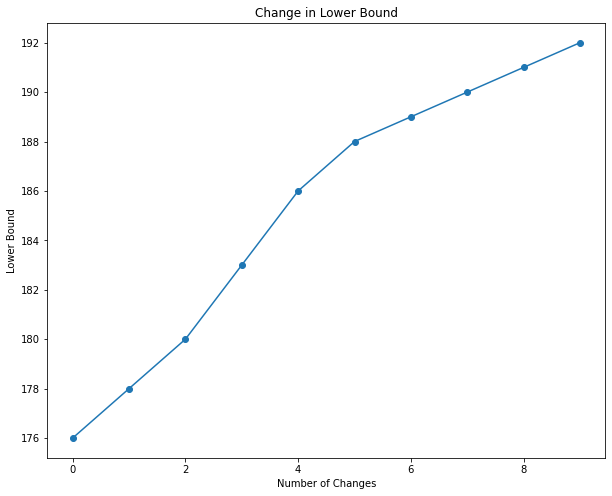

In [11]:
plt.figure(figsize=(10,8))
plt.plot(lower_bound, marker='o')
plt.xlabel("Number of Changes")
plt.ylabel("Lower Bound")
plt.title("Change in Lower Bound")